@yvan 8:45 Nov 8 2016

The goal of this notebook is to explore and analyze the assignment log dataset. Here is the description for this dataset/task:

**Part 1: Supply/demand analysis**

**Analyze and extract any interesting insights** you can derive from this data set (each row represents the assignment of a job in our research queue, including some data about the analyst who received the assignment and the current state of the research queue). **What can you infer? What do you think this means for us from a business perspective?**

```
Data fields
Analyst - who this event happened to 
Quality score - the analyst's current quality scores for the writing and sourcing jobs (calculated as a trailing avg of the last 20 job scores they've received)
Action - the event that occurred (i.e. the analyst was assigned a job, they accepted that assignment, or they declined it)
Request - the client request that this event relates to (one request requires multiple jobs to complete)
Job - the job on the knowledge assembly line that this event relates to
Wait time - the time the analyst spent waiting for a job before the event occurred
Waiting for - what jobs the analyst was waiting for when the event occurred
Analysts available - the total number of analysts that are waiting for jobs across all jobs in this dataset
Analysts occupied - the total number of analysts that are working on a job across all jobs in this dataset
Total jobs available - the total number of jobs that are waiting for an analyst to be available
```


# Data loading / Sanity check

First I'm going to load the data and check that what I have is what Andrew described.

In [1]:
import numpy as np
import pandas as pd
df_log = pd.read_csv('assignment_log.csv')
df_log.head()

,Event occurred at,Analyst,Quality score (sourcing),Quality score (writing),Action,Request,Request created at,Job,Wait time (min),Waiting for,Analysts available,Analysts occupied,Total jobs available,Review jobs available,Vetting jobs available,Planning jobs available,Editing jobs available,Sourcing jobs available,Writing jobs available
0,06/22/2017 19:59:06,9fcbc63ff4c8bea5cea4efad782c87cf,5.00,5.00,Accepted Job,594bec5c95e2ce005840c23a,06/22/2017 12:12:12,review,1,review,0,13,14,4,6,2,0,1,1
1,06/22/2017 19:59:02,9fcbc63ff4c8bea5cea4efad782c87cf,5.00,5.00,Assigned Job,594bec5c95e2ce005840c23a,06/22/2017 12:12:12,review,1,review,1,13,15,5,6,2,0,1,1
2,06/22/2017 19:51:30,85c7b78e76b5232cd38014ea4cdc8f56,4.35,4.35,Declined Job,594bec83fd2cf400280aa965,06/22/2017 12:12:51,writing,9,"sourcing, writing",1,12,12,5,5,1,0,0,1
3,06/22/2017 19:51:01,0e9802516f8a79dd0d45211dd4ee74af,4.50,4.50,Accepted Job,594c1f5cd7e68f0028c9062c,06/22/2017 15:49:48,sourcing,1,"sourcing, writing",1,11,12,5,5,1,0,0,1
4,06/22/2017 19:50:58,85c7b78e76b5232cd38014ea4cdc8f56,4.35,4.35,Assigned Job,594bec83fd2cf400280aa965,06/22/2017 12:12:51,writing,8,"sourcing, writing",2,11,14,5,5,2,0,1,1


In [2]:
df_log.shape

(791, 19)

It looks like we actually have the data desrcribed in the email (always worth checking) and we have 791 data points with 19 columns/features each. Let's check that the columns actually match with the columns Andrew talked about in the email. Let's take a look at the datatypes in our data frame. We want to know what type of data we have. Generally numerical data is good and text data is a little more difficult. The types below look mostly numeric (int64, float64) but we've also got text (object) data.

In [3]:
df_log.dtypes

Event occurred at            object
Analyst                      object
Quality score (sourcing)    float64
Quality score (writing)     float64
Action                       object
Request                      object
Request created at           object
Job                          object
Wait time (min)               int64
Waiting for                  object
Analysts available            int64
Analysts occupied             int64
Total jobs available          int64
Review jobs available         int64
Vetting jobs available        int64
Planning jobs available       int64
Editing jobs available        int64
Sourcing jobs available       int64
Writing jobs available        int64
dtype: object

It looks like everything Andrew talked about is here and there's also some fields he didn't mention. That's good, more information on each data point will probably be helpful. Next we will investigate some of the non numerical object data types. I want to know how many types of thing are in the 'Action,' 'Job,' and 'Waiting for' columns.

In [4]:
df_log['Action'].value_counts()

Assigned Job    393
Accepted Job    303
Declined Job     95
Name: Action, dtype: int64

In [5]:
df_log['Job'].value_counts()

sourcing         211
writing          160
review           143
planning          94
vetting           94
source review     58
editing           31
Name: Job, dtype: int64

In [6]:
df_log['Waiting for'].value_counts()

sourcing                                         158
sourcing, writing                                 94
review                                            91
writing                                           68
review, planning, editing, sourcing, writing      66
planning                                          48
vetting, planning, editing, sourcing, writing     46
review, vetting, editing, sourcing, writing       32
vetting                                           27
review, planning                                  24
editing, sourcing, writing                        23
editing                                           22
review, editing, sourcing, writing                15
planning, editing, sourcing, writing              13
review, vetting                                   10
vetting, planning, sourcing                        8
vetting, editing, sourcing                         7
review, editing                                    6
review, vetting, planning, sourcing           

We should turn these text values into numbers. We should also rename ur columns to get rid of spaces, etc.

# Formatting, Conversion

In [7]:
from sklearn.preprocessing import LabelEncoder

# converts all column names to lowercase
# replaces spaces with underscrores
df_log.columns = [x.replace(' ', '_') for x in map(lambda x: x.lower(), df_log.columns)]

# replace the date fields with a datetime indices
df_log['event_occurred_at'] = pd.to_datetime(df_log['event_occurred_at'], infer_datetime_format=True)
df_log['request_created_at'] = pd.to_datetime(df_log['request_created_at'], infer_datetime_format=True)

# turn text into numeric classes
action_lbl = LabelEncoder()
action_lbl.fit(list(df_log['action'].values))
df_log['action'] = action_lbl.transform(list(df_log['action'].values))

job_lbl = LabelEncoder()
job_lbl.fit(list(df_log['job'].values))
df_log['job'] = job_lbl.transform(list(df_log['job'].values))

In [8]:
df_log.dtypes

event_occurred_at           datetime64[ns]
analyst                             object
quality_score_(sourcing)           float64
quality_score_(writing)            float64
action                               int64
request                             object
request_created_at          datetime64[ns]
job                                  int64
wait_time_(min)                      int64
waiting_for                         object
analysts_available                   int64
analysts_occupied                    int64
total_jobs_available                 int64
review_jobs_available                int64
vetting_jobs_available               int64
planning_jobs_available              int64
editing_jobs_available               int64
sourcing_jobs_available              int64
writing_jobs_available               int64
dtype: object

In [9]:
df_log['action'].value_counts()

1    393
0    303
2     95
Name: action, dtype: int64

In [10]:
df_log['job'].value_counts()

4    211
6    160
2    143
5     94
1     94
3     58
0     31
Name: job, dtype: int64

We've encoded all the job and action object types as numbers and they seem to match up with how many tyreps there was before. I did not encode the waiting for object types because each field entry is actually a list; we'll deal with it later. Now let's start visualizing the data points and the relationships between the columns/features. 

# Missing Data Check

We want to check to see if our dataset has msissing values. We also want to know which columns are missing values. For example if there's any date periods where we failed to get data. First we will count the missing values.

In [11]:
df_log.isnull().sum()

event_occurred_at           0
analyst                     0
quality_score_(sourcing)    0
quality_score_(writing)     0
action                      0
request                     0
request_created_at          0
job                         0
wait_time_(min)             0
waiting_for                 6
analysts_available          0
analysts_occupied           0
total_jobs_available        0
review_jobs_available       0
vetting_jobs_available      0
planning_jobs_available     0
editing_jobs_available      0
sourcing_jobs_available     0
writing_jobs_available      0
dtype: int64

In [12]:
df_log[df_log.isnull().any(axis=1)]

,event_occurred_at,analyst,quality_score_(sourcing),quality_score_(writing),action,request,request_created_at,job,wait_time_(min),waiting_for,analysts_available,analysts_occupied,total_jobs_available,review_jobs_available,vetting_jobs_available,planning_jobs_available,editing_jobs_available,sourcing_jobs_available,writing_jobs_available
195,2017-06-22 14:30:59,9fa24ddce8fd9d1526d9d7451304fc74,4.89,4.89,0,594bec7ffd2cf400280aa953,2017-06-22 12:12:47,4,26,NaN,5,15,8,0,3,5,0,0,0
340,2017-06-22 08:01:25,a29fe6d26c1a49ff4a3c876eaee0a1af,0.00,0.00,0,594a9ce6c864e200288e766b,2017-06-21 12:20:54,4,1,NaN,3,10,3,0,0,1,0,0,2
392,2017-06-22 06:13:40,766d3435eda76c4de9f034b8f97a0602,3.50,3.50,0,594a8fd422b3c50028e71976,2017-06-21 11:25:08,6,1,NaN,0,9,6,3,1,0,0,0,2
454,2017-06-22 04:40:07,7e22ad15724c44543d1d4bcafd10c812,5.00,5.00,0,594af3c6f3b9f600287eabe0,2017-06-21 18:31:34,2,1,NaN,0,15,7,3,1,0,0,0,3
595,2017-06-21 23:23:02,f7f7591403c6c431053920223069550a,5.00,5.00,0,594b20ee3f82d10028f03c74,2017-06-21 21:44:14,1,1,NaN,0,23,7,1,3,1,0,1,1
723,2017-06-21 21:24:44,206de922289a1f9f5ee250fc71308628,3.17,3.17,0,594ae6fb4f06e20035d92345,2017-06-21 17:36:59,6,1,NaN,1,20,8,6,1,0,0,0,1


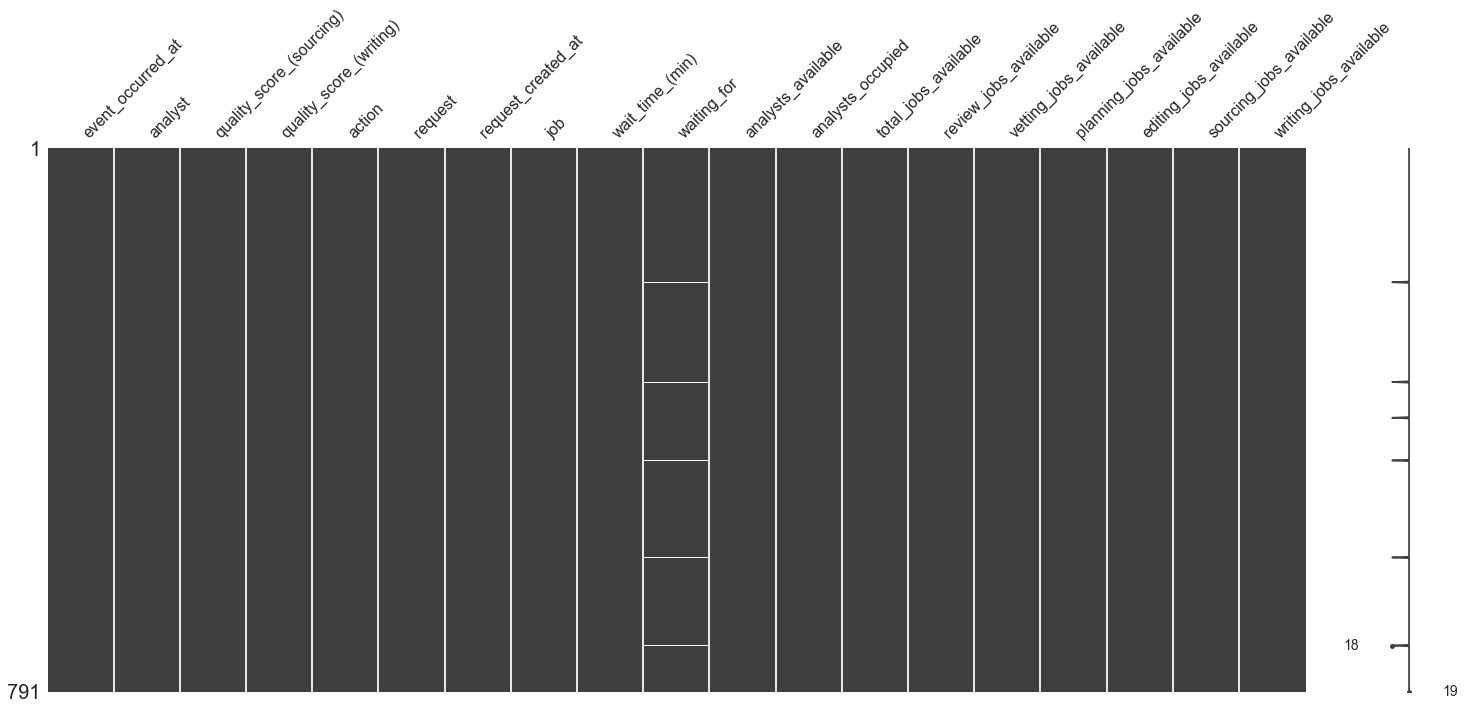

In [13]:
import missingno as msno
msno.matrix(df_log)

There does not appear to be a pattern to the missing data (dates, users, etc) but well keep it in mind.

# Exploratory Data Analysis (distributions)

Now we'll start examining distributions of columns.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

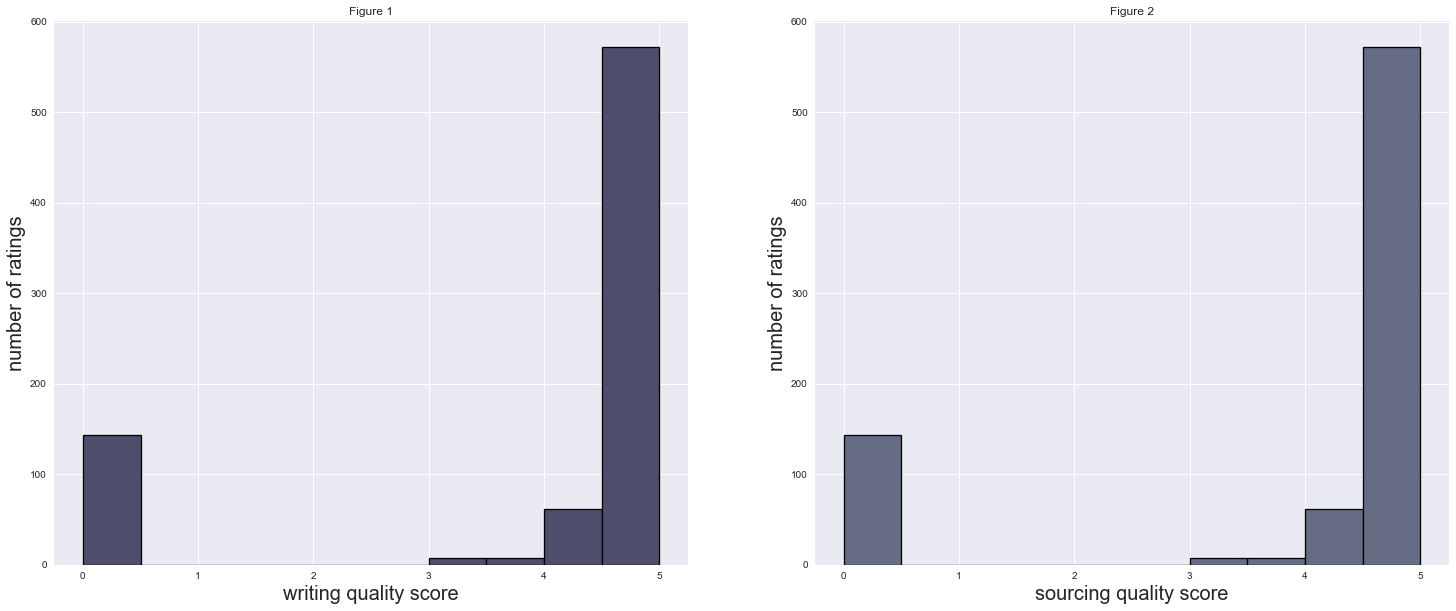

In [15]:
# pick 6 rarndom colors from the viridis color palette
bone = plt.cm.get_cmap('bone')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
ax[0].hist(df_log['quality_score_(writing)'], edgecolor='black', linewidth=1.3, color=bone(0.35))
ax[0].set_xlabel ('writing quality score', fontsize=20)
ax[0].set_ylabel('number of ratings', fontsize=20)
ax[0].set_title('Figure 1')

ax[1].hist(df_log['quality_score_(sourcing)'], edgecolor='black', linewidth=1.3, color=bone(0.45))
ax[1].set_xlabel ('sourcing quality score', fontsize=20)
ax[1].set_ylabel('number of ratings', fontsize=20)
ax[1].set_title('Figure 2')

plt.show()

These quality score seem to be the same feature. Let's verify this and then combine those fields.

In [16]:
# verify that the scores are the same
assert (df_log['quality_score_(writing)'] == df_log['quality_score_(sourcing)']).all()

# make a single quality_score
df_log = df_log.drop('quality_score_(writing)', axis=1)
df_log = df_log.rename(columns={'quality_score_(sourcing)': 'quality_score'})
assert 'quality_score' in df_log.columns
assert 'quality_score_(writing)' not in df_log.columns and 'quality_score_(sourcing)' not in df_log.columns

**Analysis**:

Ok they are the same and I've replaced them with a single score. I'm not totall sure what's going on here but I see two courses of action. I think we should record different values for these fields as their names imply. If the values were actually two different scores then you could route sourcing requests to people with higher sourcing scores and writing requests to people with higher writing scores. It also seems unlikely that it's just one person doing sourcing then writing because the number of sourcing jobs is roughly 100 more than the number of writing jobs. 

**Business Implication**:

Improve the quality of reports by knowing which analysts are better at what. Wonder can make more money from existing clients and attract new clients with higher quality reports. 

Next let's look at actions and jobs.

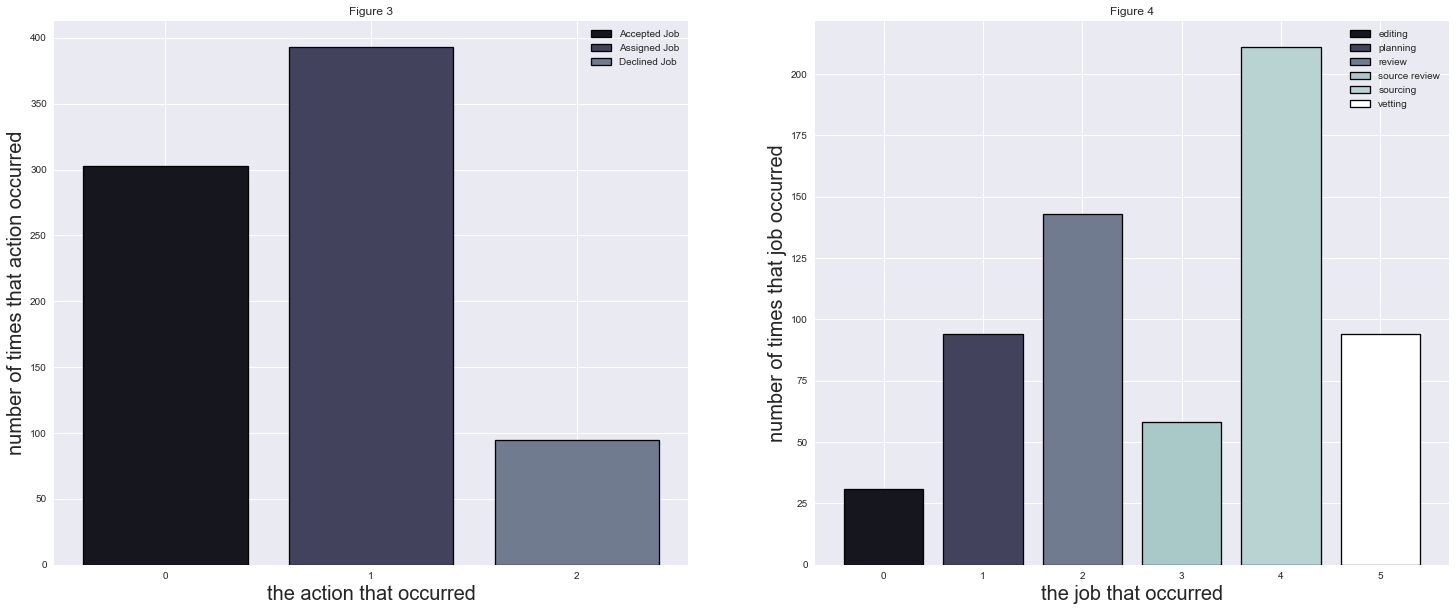

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

colors = [0.1, 0.3, 0.5, 0.75, 0.8, 1.0]

for i in range(0, 3):
    ax[0].bar(i, 
              df_log['action'].value_counts()[i], 
              align='center',
              edgecolor='black', 
              linewidth=1.3, 
              color=bone(colors[i]),
             label=action_lbl.inverse_transform([i])[0])
ax[0].set_xlabel ('the action that occurred', fontsize=20)
ax[0].set_ylabel('number of times that action occurred', fontsize=20)
ax[0].set_xticks([0, 1, 2])
ax[0].legend(loc='upper right')
ax[0].set_title('Figure 3')

for i in range(0, 6):
    ax[1].bar(i, 
              df_log['job'].value_counts()[i],
              align='center',
              edgecolor='black',
              linewidth=1.3,
              color=bone(colors[i]),
              label=job_lbl.inverse_transform([i])[0])
ax[1].set_xlabel ('the job that occurred', fontsize=20)
ax[1].set_ylabel('number of times that job occurred', fontsize=20)
ax[1].set_xticks([0, 1, 2, 3, 4, 5])
ax[1].legend(loc='upper right')
ax[1].set_title('Figure 4')

plt.show()

**Inferences**:

*Editing* is where someone gets a job to actually modify a response to question.

*Planning* is the process of putting sources, writing and other products together, or coordinating what other jobs need doing.

*Review* is a peer driven process where one analyst leaves a score for the work of another analyst.

*Source* review is a peer drvien process where one analyst asseses and scores the quality of another analyst's sources (reserch papers, surveys, expert writings, etc).

*Sourcing* is the process of finding data or high quality knowledge that backs up the response to a question.

*Vetting* is the process of verifying that a source is indeed authoritative or legitemate.

*Writing* is the process of writing the actual answer the the question.

**Analysis**:

There are 95 declined jobs. I'm assuming these are jobs you assign to analysts who then decide for one reason or another that they don't want that job. Obviously it would be better if this number were lower because assigned jobs that get rejected probably have to go back into a queue system and get reassigned. 

The two most frequent jobs are sourcing and writing. That makes sense answers need to be researched and written. The third most common job is review. This also makes sense; reports need to be reviewed to ensure quality before they can be sent to a client. 

**Business Implication**:

Question responses are only as fast as the slowest sub-job, so higher declined job rates may hurt relaiblity, and response time. One solution is to maybe ask analysts to specify a reason for declining a job. Obviously if some jobs are less desriable then analysts might lie. Obtaining honset feedback on declined jobs should bea priority for the product team.

To improve performace of analysts it may be valuable to improve the efficiency of writing and sourcing tasks. Writing could be sped up using response templates that ensure consistency and speed. sourcing could be improved if internal bookmarks on previously sourcd topics were maintained, which would lower search time and improve consistency for topics that have already been sourced before.

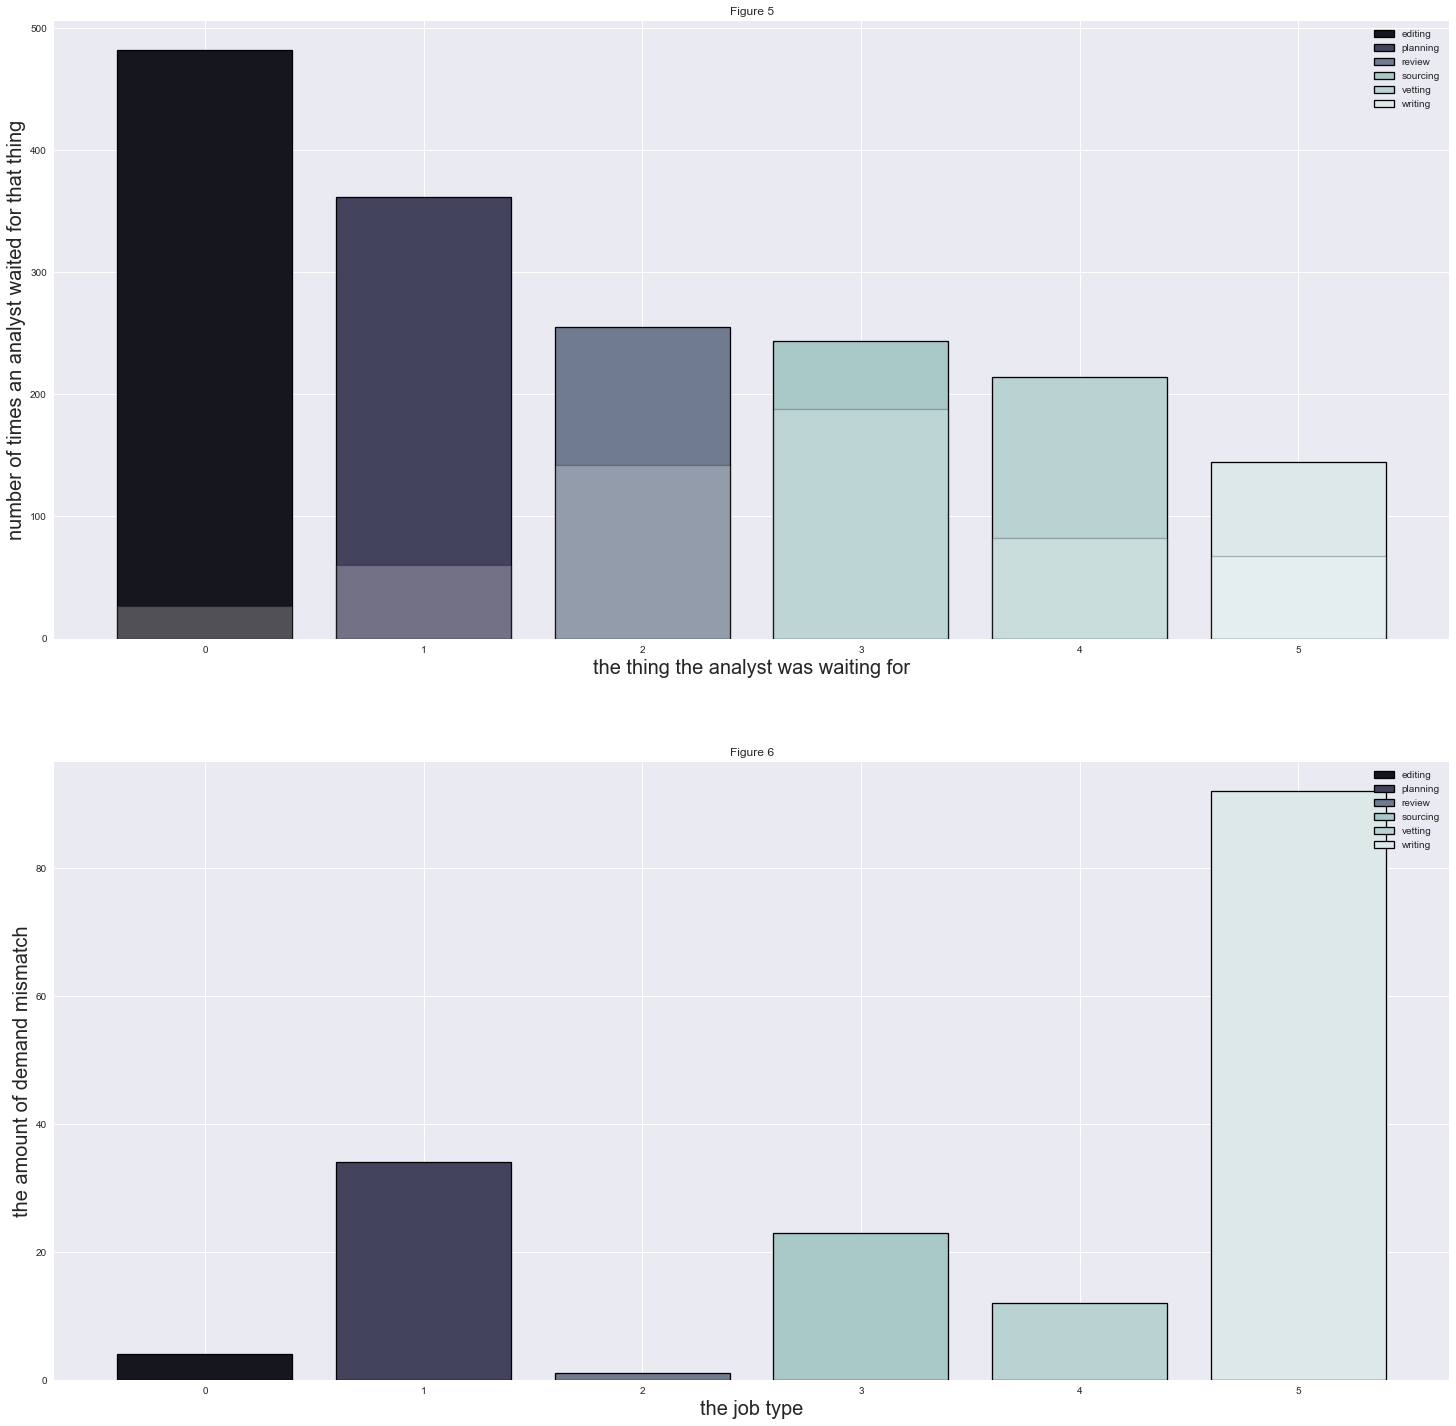

In [18]:
# collect, and normalize all the reasons an analyst has to wait
waiting_array = [w.strip().lower() for w in df_log['waiting_for'].str.cat(sep=',').split(',')]

colors = [0.1, 0.3, 0.5, 0.75, 0.8, 0.9, 1.0]

waiting_lbl = LabelEncoder()
waiting_lbl.fit(waiting_array)
hist_array = waiting_lbl.transform(waiting_array)
waiting_counts = pd.Series(waiting_array).value_counts()

fulfilled_waiting_for_job = {c:0 for c in waiting_lbl.classes_}
for job, waiting_for in zip(df_log['job'], df_log['waiting_for']):
    job = job_lbl.inverse_transform([job])[0]
    if type(waiting_for) == str and job in waiting_for.split(','):
        fulfilled_waiting_for_job[job] += 1

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(25, 25))
for i in range(0, 6):
    ax[0].bar(i, 
              waiting_counts[i],
              align='center',
              edgecolor='black',
              linewidth=1.3,
              color=bone(colors[i]),
              label=waiting_lbl.inverse_transform([i])[0])
    ax[0].bar(i, 
              fulfilled_waiting_for_job[waiting_lbl.inverse_transform([i])[0]],
              align='center',
              edgecolor='black',
              linewidth=1.3,
              color=bone(1.0),
              alpha=0.25)
ax[0].set_xlabel ('the thing the analyst was waiting for', fontsize=20)
ax[0].set_ylabel('number of times an analyst waited for that thing', fontsize=20)
ax[0].set_xticks([0, 1, 2, 3, 4, 5 ])
ax[0].legend(loc='upper right')
ax[0].set_title('Figure 5')

# needs its own loog because there is
# an extra job type in one of them
plot_vals = []
for k,v in fulfilled_waiting_for_job.items():
    encoded_label = job_lbl.transform([k])[0]
    plot_vals.append(df_log['job'].value_counts()[encoded_label] - v)
    
for i in range(0, 6):
    fulfilled_waiting_for_job[waiting_lbl.inverse_transform([i])[0]]
    ax[1].bar(i,
              plot_vals[i],
              align='center',
              edgecolor='black',
              linewidth=1.3,
              color=bone(colors[i]),
              label=waiting_lbl.inverse_transform([i])[0])

ax[1].set_xlabel ('the job type', fontsize=20)
ax[1].set_ylabel('the amount of demand mismatch', fontsize=20)
ax[1].set_xticks([0, 1, 2, 3, 4, 5 ])
ax[1].legend(loc='upper right')
ax[1].set_title('Figure 6')

plt.show()

Figure 5 above shows the number of jobs being waited on for each type of job. The pale (see through) white on each bar represents the number of that job that was waited for and occurred ('job' is in 'waited_for' list for that row). This chart just reveals the prefrences of the analysts and how well those preferences are being fulfilled.

A low efficiency tells us that the preferences of analysts are not being satisfied, a higher efficiency tells us that analyst preferences are being better satisfied. There is way more desire from analysts to do editing jobs than there are editing jobs available (5% demand efficiency). We could Split editing work to create more editing jobs for analysts that would help to fulfill their prferences. Future product decisions could be made to get more editors on the platform.

In [19]:
for i in range(0, 6):
    print(waiting_lbl.inverse_transform([i])[0] + ' efficiency: ', fulfilled_waiting_for_job[waiting_lbl.inverse_transform([i])[0]] / waiting_counts[i] )

editing efficiency:  0.0560165975104
planning efficiency:  0.165745856354
review efficiency:  0.556862745098
sourcing efficiency:  0.770491803279
vetting efficiency:  0.383177570093
writing efficiency:  0.468965517241


If we subtract the pale bar from the number of times a job occurred overall we get the demand mismatch. This is how much of the job we gave to people who didn't ask for it. I've graphed this in Figure 6! The thing that's a bit concerning is that the biggest mismatch in demand comes from writing. This means that the amount of writing we have to give out that is unasked for is high.

This begs another question, does a mismatch lead to a declined job? Let's answer it next.

In [20]:
job_mismatches_declined = {c:{'mismatches':0, 'declined':0} for c in waiting_lbl.classes_}
# grab all the instances where there was a job mismatch
for job, waiting_for, action in zip(df_log['job'], df_log['waiting_for'], df_log['action']):
    job = job_lbl.inverse_transform([job])[0]
    if  job == 'source review':
        job = 'review'
    if type(waiting_for) == str and job not in waiting_for.split(','):
        job_mismatches_declined[job]['mismatches'] += 1
        # it he job was declined
        if action == 2:
            job_mismatches_declined[job]['declined'] += 1
for k,v in job_mismatches_declined.items():
    print('{} mismatches: {} declines:{} decline rate :{}'.format(k, v['mismatches'],  v['declined'], v['declined']/(v['mismatches']+1)))

editing mismatches: 4 declines:1 decline rate :0.2
planning mismatches: 33 declines:6 decline rate :0.17647058823529413
review mismatches: 0 declines:0 decline rate :0.0
sourcing mismatches: 21 declines:0 decline rate :0.0
vetting mismatches: 12 declines:0 decline rate :0.0
writing mismatches: 90 declines:15 decline rate :0.16483516483516483


It looks like when there is a mismatch decline rate is 16-20%. Versus the baseline decline rate for noraml job arrignments (not mismatches) (95-22)/(393-160) = 0.3133. It does not appear that mismatches increase an analyst's decision to decline.

Do declined jobs re-enter the queue? How long do they take to get reassigned?

In [21]:
# get the ids of declined jobs
declined_job_ids = df_log[df_log['action'] == 2]['request']
declined_request_times = df_log[df_log['action'] == 2]['request_created_at']

# how many jobs are declined at least 2x?
print('number of jobs declined at least 2x: {}'.format(len(declined_job_ids) - len(declined_job_ids.drop_duplicates())))

declined_time_dict = {job_id:{'req_time':request_time, 'final_time':request_time} for job_id,request_time in zip(declined_job_ids,declined_request_times)}

# for each declined id check how many times it was declined
for job_id in declined_job_ids:
    final_time_candidate = df_log[df_log['request'] == job_id]['event_occurred_at']
    if final_time_candidate.max() > declined_time_dict[job_id]['final_time']:
        declined_time_dict[job_id]['final_time'] = final_time_candidate.max()

times_added = [v['final_time'] - v['req_time'] for k,v in declined_time_dict.items()]
print('mean time added by declined jobs: {}'.format(pd.Series(times_added).mean()))
print('total time added by declined jobs: {}'.format(pd.Series(times_added).sum()))

number of jobs declined at least 2x: 66
mean time added by declined jobs: 0 days 10:48:44.655172
total time added by declined jobs: 13 days 01:33:35


So it looks like:

Declined jobs do re-enter the queue.

Declined jobs can add close to 13 days of added time to a job.

Declined jobs on average add 11 hours of time to a job.

If we could match jobs better we could lower this time added from declined jobs and answer questions faster (make more revenue, have happier clients and analysts). I've assumed here that the last time an event occurs for a request id is when that request is 'fulfilled' obviously this isn't a perfect assumption; the request is probably fulfilled sometime after that point. It's probably alright to make here though.

Let's look at job availability over time.

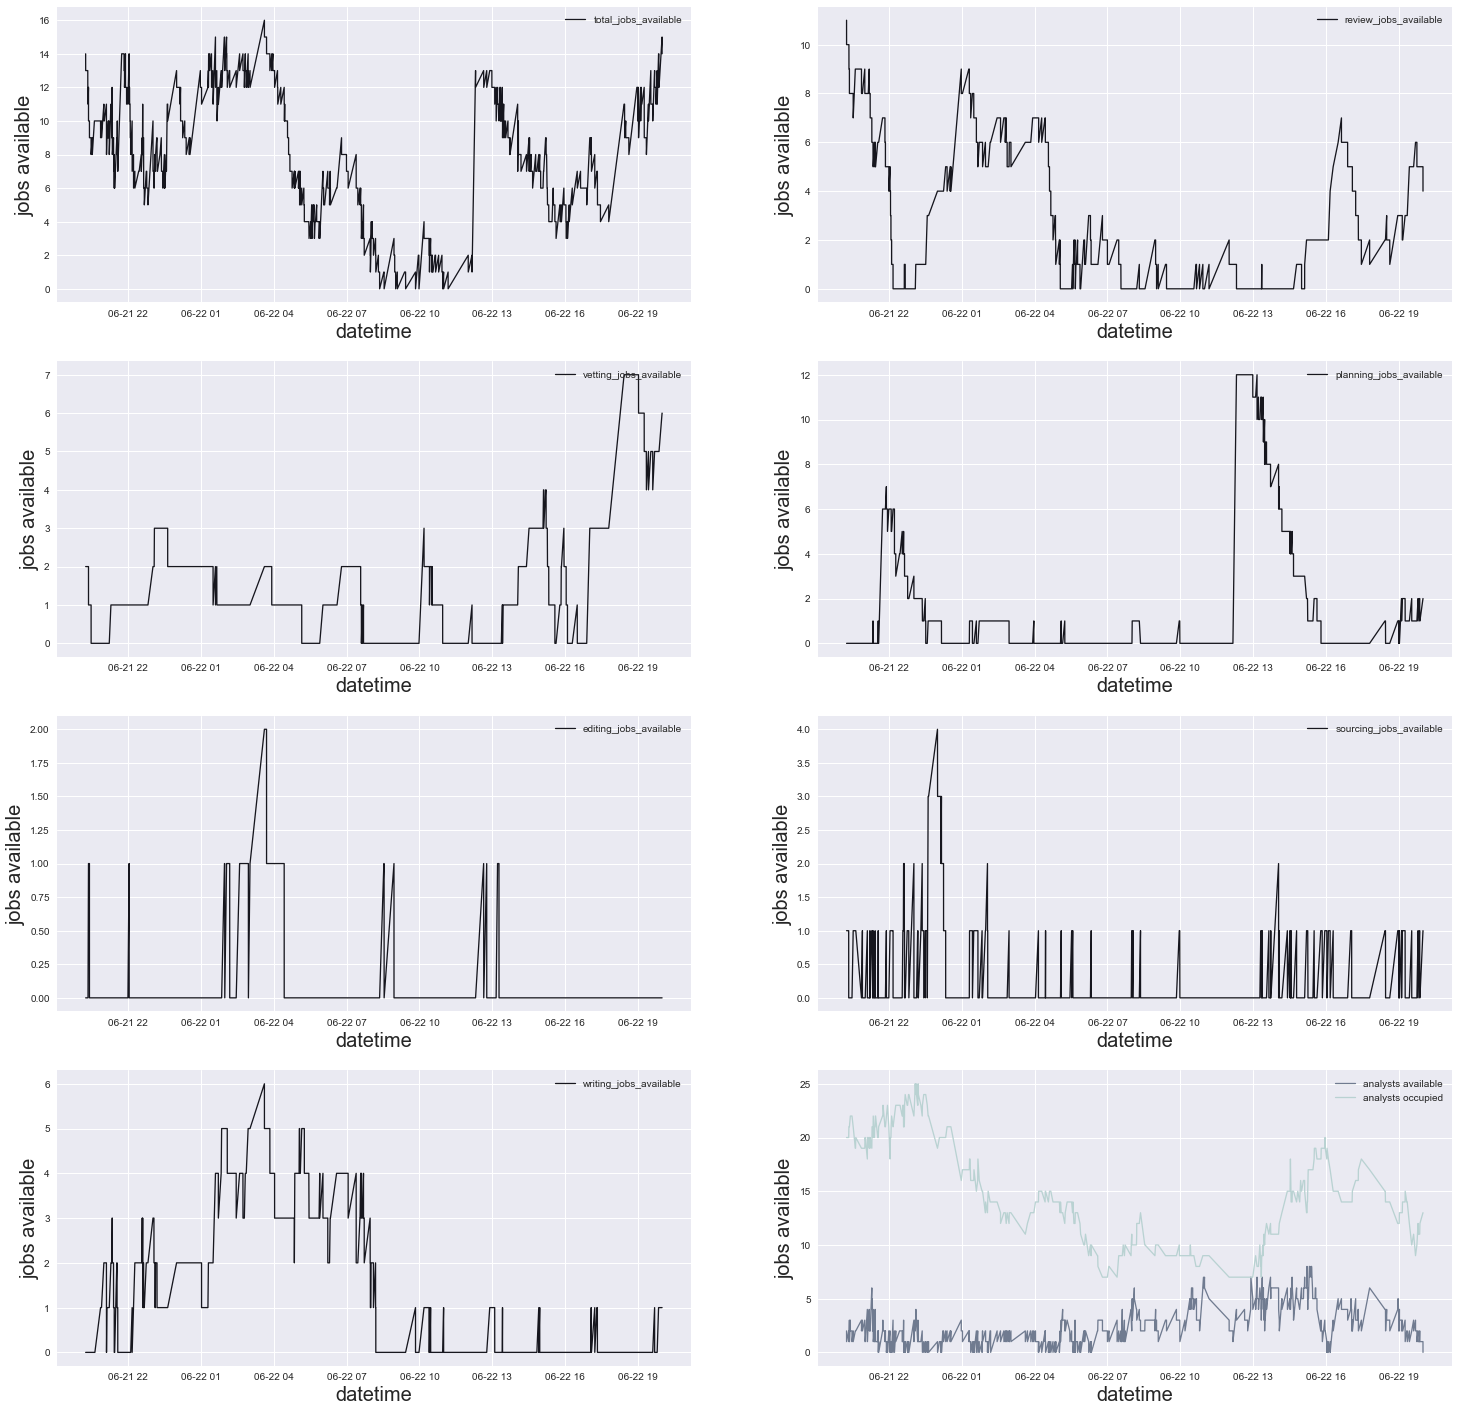

In [22]:
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))

columns = ['total_jobs_available',
'review_jobs_available',
'vetting_jobs_available',
'planning_jobs_available',
'editing_jobs_available',
'sourcing_jobs_available',
'writing_jobs_available']

df_log.index = df_log['event_occurred_at']
df_log.index

i = 0
for row in range(nrows):
    for col in range(ncols):
        if row == 3 and col == 1:
            break
            
        ax[row][col].plot(df_log['event_occurred_at'], 
                          df_log[columns[i]],
                          linewidth=1.3,
                          color=bone(colors[0]),
                          label=columns[i])
        ax[row][col].set_xlabel ('datetime', fontsize=20)
        ax[row][col].set_ylabel('jobs available', fontsize=20)
        ax[row][col].legend(loc='upper right')
        i += 1
        
ax[-1][-1].plot(df_log['event_occurred_at'], 
                  df_log['analysts_available'],
                  linewidth=1.3, 
                  color=bone(colors[2]),
                  label='analysts available')
ax[-1][-1].set_xlabel ('datetime', fontsize=20)
ax[-1][-1].set_ylabel('jobs available', fontsize=20)

ax[-1][-1].plot(df_log['event_occurred_at'], 
                  df_log['analysts_occupied'],
                  linewidth=1.3, 
                  color=bone(colors[4]),
                  label='analysts occupied')
ax[-1][-1].set_xlabel ('datetime', fontsize=20)
ax[-1][-1].set_ylabel('jobs available', fontsize=20)
ax[-1][-1].legend(loc='upper right')
        
plt.show()

**Analysis**:

The supply of jobs drops off dramatically from 06-04 to 06-13. If this is UTC time 04:00 UTC is about 11PM NYC time. 13:00 UTC is about 8AM NYC time. During this preiod available analysts is close to 0 and occupied analysts continously fall (from 5PM onwards). This seems to suggest that wonder's clients are mostly U.S. east coast based and that a drop in available jobs is not due to more analysts logging on and absrobing excess jobs.

At 7:30-8 AM there is a huge surge in overall jobs. This appears to be driven by and large by an increase in planning type jobs. In the morning clients submit questions and then before anything else can happen with that question the planning jobs to coordinate the responses go out. 

Vetting really takes off as we start to approach noon.

In an ideal world the total jobs avaialable graph would be a flat line near 0. What this graph really tells us is where wonder is failing to match up jobs with analysts at least temporarily. That said the sourcing graph seems quite efficient. So is editing.

**Takeaways**:

If I was trying to schedule demand I'd say we need more analysts waiting for planning around 8AM. Analysts actually want planning (see Figure 5) but we still get a huge buildup of planning jobs in the early morning. This implies that this is probably a timing issue. This may be because clients get in early and analysts who work from home sleep in later. Maybe we could pay more for those jobs in the morning to incentivize analysts to wake up a little earlier. The thing that is still a bit weird is that while planning jobs build up there are actually plenty of available analysts (around 5-7).

Writing seems to build up all in one part of the day (5PM - 2AM). During the same period these is also a bump upwards in available review, planning, vetting, sourcing and highly desired editing jobs. Thes writing and review buildups in this period are bigger than all the others.  There is close to zero 'available analysts' during the period and occuppied analysts consistently fall off. In other words it seems that analysts are logging off during this period causing jobs to build up.

Sourcing and editing seem to be very efficient. There isn't really a buildup in those jobs. We should investigate those; they may be a model for figuring out how to effciently fill jobs. If you look at Figures 5, 6 editing has the lowest demand mismatch but sourcing has one right above 20. This implies we are doing a good job at matching editing jobs and aligning those jobs analyst preferences. It seems we are achieving sourcing efficiency at the cost of assigning those jobs to people who didn't want them (roughly 25 jobs).

After looking at these supply graphs and looking at mismatched demand it got me thinking about how I could reverse engineer wonder's job queue assignment system. Here is how I think it works:

Below a certain threshold wonder lets jobs build up and only assigns jobs to people who asked for that job. Once the a type of job reaches a certain threshold wonder just says 'screw it' and starts assigning those jobs to people who didn't necessarily ask for that job type. If we look at planning this seems to be supported by the evidence. Planning builds up while analysts are available, then wonder starts assigning jobs to available anlysts causing the number of available analysts to fall as the planning jobs get assigned (many analysts also log on at that time). This would also explain the large demand mismatch in Figure 6 for planning.

Next I want to look at the wait times and see if any patterns stand out.

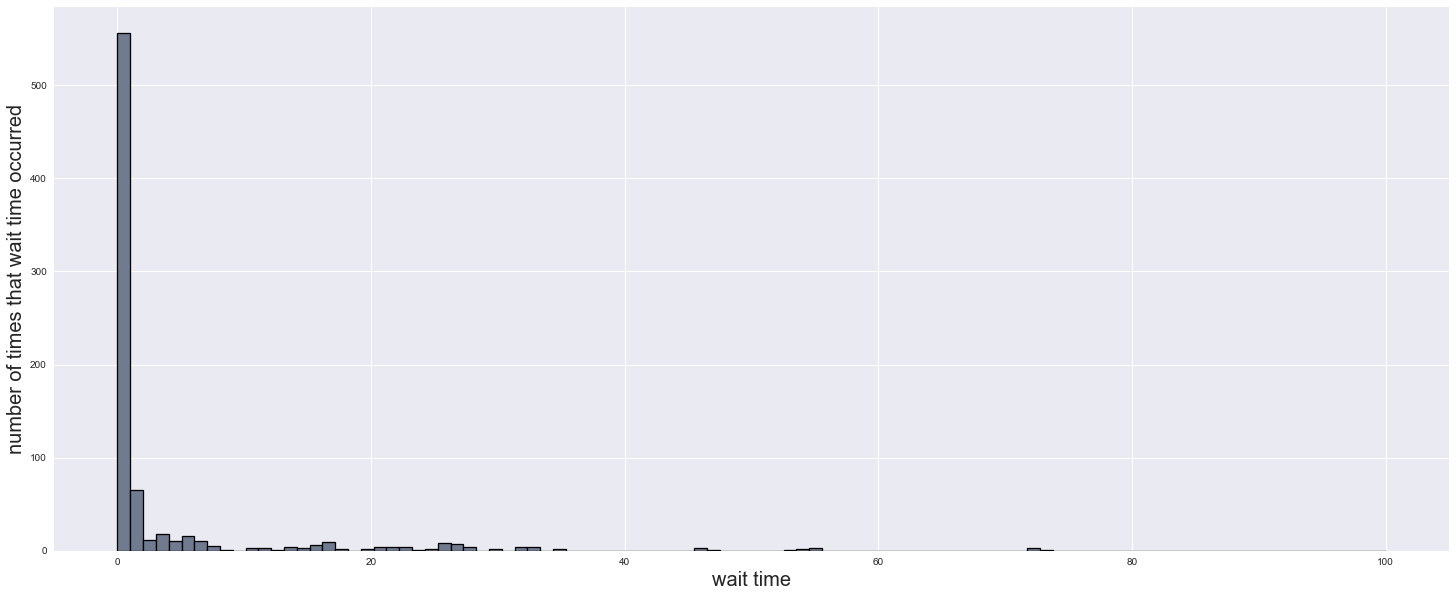

In [23]:
plt.figure(figsize=(25,10))
plt.hist(df_log['wait_time_(min)'], bins=np.linspace(0,100,100), edgecolor='black', linewidth=1.3, color=bone(0.5))
plt.xlabel ('wait time', fontsize=20)
plt.ylabel('number of times that wait time occurred', fontsize=20)
plt.show()

The wait time data looks like a long tailed distribution. Let's check a few thresholds values for wait times.

In [24]:
print('<=1: {}, >1: {}, >10: {}, >25: {}, >50: {}, >100: {}'.format(
(df_log['wait_time_(min)'] <= 1).sum(),
(df_log['wait_time_(min)'] > 1).sum(), 
(df_log['wait_time_(min)'] > 10).sum(),
(df_log['wait_time_(min)'] > 25).sum(), 
(df_log['wait_time_(min)'] > 50).sum(), 
(df_log['wait_time_(min)'] > 100).sum()))

<=1: 556, >1: 235, >10: 97, >25: 49, >50: 14, >100: 4


Most of the wait times are a minute or lower which is good. But there is a sizeable portion of wait times that are well above 10 minutes.

Does waiting for particular jobs increase wait time? Does this affect demand for those jobs?

In [25]:
waiting_for_longtime = df_log[df_log['wait_time_(min)'] > 10]['waiting_for']
waiting_array_longtime = pd.Series([w.strip().lower() for w in waiting_for_longtime.str.cat(sep=',').split(',')])

waiting_for_shorttime = df_log[df_log['wait_time_(min)'] < 10]['waiting_for']
waiting_for_shorttime = pd.Series([w.strip().lower() for w in waiting_for_shorttime.str.cat(sep=',').split(',')])

In [26]:
waiting_for_shorttime.value_counts(normalize=True)

sourcing    0.266367
writing     0.211810
review      0.151476
editing     0.146341
planning    0.134788
vetting     0.089217
dtype: float64

In [27]:
waiting_array_longtime.value_counts(normalize=True)

sourcing    0.465278
writing     0.222222
review      0.131944
editing     0.111111
vetting     0.041667
planning    0.027778
dtype: float64

**Analysis**:

It looks like if an analyst is waiting more than 10 minutes for an assignment they are 2x more likely to have 'sourcing' listed on your waiting_for list. The only other differences big enough to note are planning and vetting (2x more) and planning and vetting (2x more).

I think the incrase in waiting for *planning* is because planning happens around 2 points in the 'day' and if you are waiting for it and you arent' at one of those two points there aren't a whole lot of excess planning jobs to get so an analyst will have to wait longer.

I think the incraese in waiting for *sourcing* is just because sourcing is relatively efficient and so there aren't a whole lot of excess sourcing jobs. So if you're waiting for just sourcing you might wait longer 9other people get the jobs.

I'm not too sure about the mechanics driving vetting.

Sorucing, planning, and vetting all have a sizable amount of 'demand mismatch' as we saw before. The fact that people wait a long time to do sourcing and that still much of the sourcing is going to people who didn't ask for it indicates there may be an issue with the routing of that particular job type.

# Conclusion

I'm going to summarize some of my thoughts and maybe offer some recommendations based on what I've seen here. There is a lot to cover so I'll keep each point brief.

**ACTION**: We could improve the quality of our routing by keeping separate scores for writing and sorucing. There is a sizeable demand mismatch for both of those jobs. If we could get a sense for which analysts are better at each task we could lower that mismatch.

**ACTION**: We should ask users why they are declining a job. Knowing why a user declined a job will help us find a better match next time and avoid costs associated with re-assigning a job.

**ACTION**: Split editing work to create more editing jobs and make it easier to get them. These jobs are clearly in high demand. Given the astonomical demand for editing type jobs there should never be more than 0-1 available editing jobs. Increasing these jobs creates all kinds of benefits: happier analysts, smoother/lower supply curve for editing, more revenue for wonder.

**ACTION**: There's a lot more writing than analysts want to do. Demand mismatch for writing must be addressed. Maybe writing jobs could be split up as well and turned into smaller tasks to make them more desirable. The inefficiency seems to come from the 5PM-2AM period. Nobody wants to start writing someting in the evening. I understand that; I usually do not start writing a new blog after 5PM; My creative juices get spent in the morning/afternoon. Writing and sourcing are what I would consider 'core' jobs. We should try to firgue out how to make writing after 5PM attractive (not sure this can e done) or maybe recruit some englih speaking analysts in a different time zone who are willing to write during 5PM-2AM us east time.

**ACTION**: Measure individual analyst preferences and try to encourage analysts to log on for times that line up well with their job prefernces. If an analyst prefers planning work we can say 'you can expect there to be a lot of planning work at 7:30 AM' and we can encourage that analyst to log on then ant take those jobs then. This also has the added effect of lowering the excess of available planning jobs at the two points in the day when they occur. Knowing the indidivual prefernces of analysts and our own excess supply curves allows analysts to make more money and allows wonder to make more money by having a more efficient job matching process. This is also supported by the fact that when users do wait a long time they more likely to be waiting for rsorucing and planning. A simple notification about when to log on to get those jobs would probably reduce those wait times.

**ACTION**: Model the tradeoff between efficiency and demand mismatch. afetr 
looking at this data i suspect there is a relationship between how efficient our 'available jobs' curve is for a particular type of job and the demand mismatch amoutn for that job type. In other words, all things equal, we can get higher efficiency curves by just ignoring tsated prefernces (like it seems we're doing with some of the sourcing work but that will cause demand mismatch to increase. If we can figure out what the relationship is we can 'manage' keep available jobs lower without causing a skyrocketing demand mismatch.

**ACTION**: Expand clientele to a complimentary time zone. Looking at the aggregate jobs available it seems pretty clear that jobs are flowing in/out on an east coast schedule. Getting a clientele in australia, and hong kong (english speaking countries) with ~12 hours difference could be helpful to even out the supply of jobs.

**ACTION**: Declined jobs cost 13 days of queue time in this time period. This number has to be brought down. Wonder needs a to try to make sure assigned jobs won't be declined. Many request ids seems to get jobs declined for them multiple times. Maybe if a job gets declined 2x the request that jobs belongs to should be flagged as 'difficult' and a premium should be offered for jobs attached to that request id.

*Note*: You amy have noticed there is no modelling in this notebook. That is not a mistake. Usually it's a bad idea to try to model something you haven't at least built some intuition around. It usually takes at least a day to truly reason about the dataset you're working with. In a sense some fo the metrics and number I've calculated are very simple 'models' for reasoning about various behaviors expressed in the data.

*Note*: I've made a lot of assumptions in this notebook. I'm sure some of them are wrong but given the limited time/information constraint I prefer to make assumptions, work within them, and then re-evaluate any conclusions that come from them in the future if I can get new information.

I hope you enjoyed reading this as much as I enjoyed putting it together!

